Bibliotecas importadas com sucesso!
--------------------------------------------------
Grafo criado com 8 nós e 12 arestas.
Simulação de 20 pedidos para entrega.
--------------------------------------------------


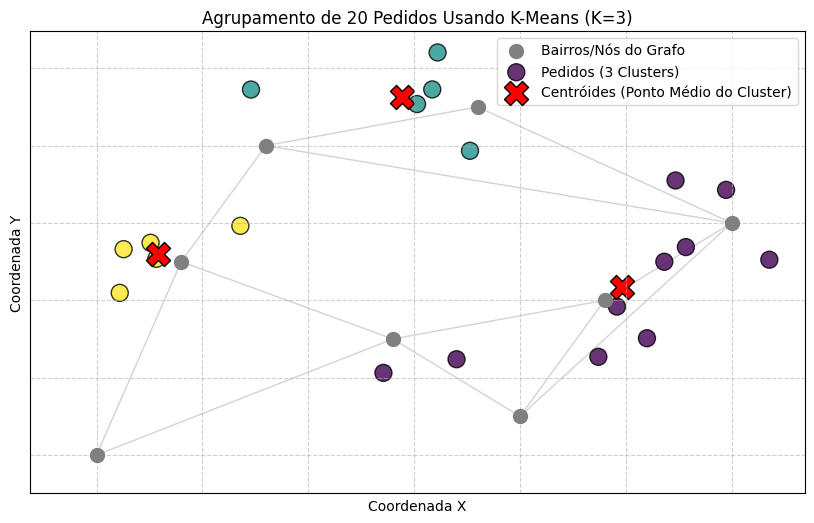

Pedidos agrupados em 3 clusters. Cada cluster representa uma rota para um entregador.
Cluster
0    10
1     5
2     5
Name: count, dtype: int64
--------------------------------------------------
O Centróide do Cluster 0 será aproximado pelo nó do grafo: **Bairro_5**

✅ Rota A* Encontrada (Restaurante -> Bairro_5):
Restaurante_A -> Bairro_2 -> Bairro_5
Custo Total da Rota: **12.71 unidades de distância/tempo**.
--------------------------------------------------


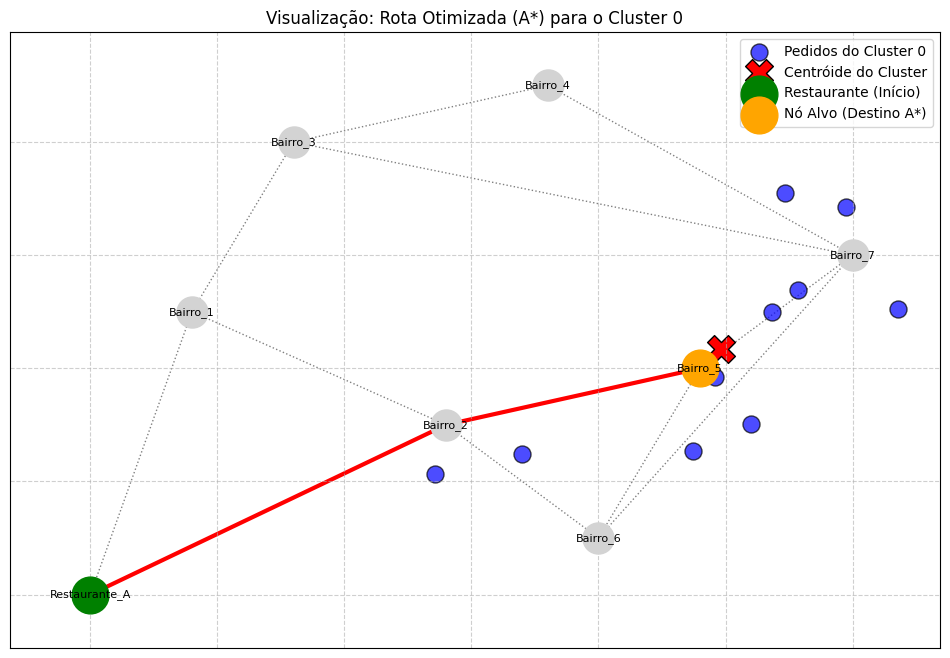


--- Próximos Passos para um Projeto Real ---
1. **Cluster -> Múltiplas Entregas:** A rota A* atual vai do Restaurante até o Centróide (via o nó mais próximo). Em um cenário real, você precisaria aplicar o **Problema do Caixeiro Viajante (TSP)** no Cluster, começando no Restaurante, passando por TODOS os pontos de entrega do cluster, e voltando ao Restaurante ou ao próximo ponto de partida.
2. **Métricas:** Comparar o custo/tempo da rota TSP/A* com a rota manual dos entregadores para quantificar a economia.
3. **Restrições:** Adicionar restrições de tempo, capacidade do entregador, tráfego (pesos dinâmicos nas arestas) para maior realismo.


In [1]:
## Célula 1: Instalação e Importação de Bibliotecas
# Instala as bibliotecas se não estiverem presentes (útil para o Google Colab)
# !pip install networkx scikit-learn pandas numpy matplotlib

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from collections import deque
import heapq # Usado para a fila de prioridade no A*

print("Bibliotecas importadas com sucesso!")
print("-" * 50)

## Célula 2: Simulação de Dados do Problema

# 1. Simulação do Grafo da Cidade (Ruas e Distâncias)
# Vamos usar um modelo simplificado de coordenadas e conexões
cidade_nos = {
    'Restaurante_A': (0, 0),  # Ponto de Partida
    'Bairro_1': (2, 5),
    'Bairro_2': (7, 3),
    'Bairro_3': (4, 8),
    'Bairro_4': (9, 9),
    'Bairro_5': (12, 4),
    'Bairro_6': (10, 1),
    'Bairro_7': (15, 6)
}

# Cria o grafo
G = nx.Graph()
for node, pos in cidade_nos.items():
    G.add_node(node, pos=pos)

# Define arestas (ruas) com pesos (distância euclidiana como proxy de tempo/custo)
arestas = [
    ('Restaurante_A', 'Bairro_1'), ('Restaurante_A', 'Bairro_2'),
    ('Bairro_1', 'Bairro_3'), ('Bairro_1', 'Bairro_2'),
    ('Bairro_2', 'Bairro_5'), ('Bairro_2', 'Bairro_6'),
    ('Bairro_3', 'Bairro_4'), ('Bairro_3', 'Bairro_7'),
    ('Bairro_4', 'Bairro_7'), ('Bairro_5', 'Bairro_6'),
    ('Bairro_5', 'Bairro_7'), ('Bairro_6', 'Bairro_7')
]

def calcular_peso(n1, n2):
    """Calcula a distância euclidiana entre dois nós para ser o peso da aresta."""
    pos1 = G.nodes[n1]['pos']
    pos2 = G.nodes[n2]['pos']
    return np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

for u, v in arestas:
    peso = calcular_peso(u, v)
    G.add_edge(u, v, weight=peso)

# 2. Simulação dos Pedidos (Pontos de Entrega)
np.random.seed(42)
num_pedidos = 20
pedidos_data = []

# Gera coordenadas aleatórias em torno dos 'bairros' simulados
bairros_list = list(cidade_nos.keys())[1:] # Exclui o restaurante
for i in range(num_pedidos):
    # Escolhe um bairro base aleatório
    base_bairro = np.random.choice(bairros_list)
    base_x, base_y = cidade_nos[base_bairro]

    # Gera coordenadas próximas ao bairro base
    x = base_x + np.random.uniform(-1.5, 1.5)
    y = base_y + np.random.uniform(-1.5, 1.5)

    pedidos_data.append({
        'ID': f'P{i+1}',
        'Localização_X': x,
        'Localização_Y': y
    })

df_pedidos = pd.DataFrame(pedidos_data)

print(f"Grafo criado com {G.number_of_nodes()} nós e {G.number_of_edges()} arestas.")
print(f"Simulação de {num_pedidos} pedidos para entrega.")
print("-" * 50)

## Célula 3: 💡 Estratégia de Agrupamento de Entregas (K-Means)

# O objetivo é agrupar pedidos próximos em 'zonas' para que um entregador possa atender um cluster completo.

# 1. Pré-processamento: Padronizar os dados
X = df_pedidos[['Localização_X', 'Localização_Y']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Determinar o número ideal de clusters (K)
# K = Número de entregadores disponíveis ou número desejado de rotas (ex: 3)
K = 3
# Para um projeto real, você usaria o Método do Cotovelo ou Silhouette para encontrar o K ideal

# 3. Aplicar K-Means
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
df_pedidos['Cluster'] = kmeans.fit_predict(X_scaled)

# 4. Visualização dos Clusters
plt.figure(figsize=(10, 6))
# Plota o grafo (mapa da cidade)
pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx_nodes(G, pos, node_size=100, node_color='gray', label='Bairros/Nós do Grafo')
nx.draw_networkx_edges(G, pos, edge_color='lightgray')

# Plota os pedidos agrupados por cor
scatter = plt.scatter(df_pedidos['Localização_X'], df_pedidos['Localização_Y'],
                      c=df_pedidos['Cluster'], cmap='viridis', s=150,
                      alpha=0.8, edgecolors='k', label=f'Pedidos ({K} Clusters)')

# Plota os centróides (pontos médios dos clusters)
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=300,
            c='red', label='Centróides (Ponto Médio do Cluster)', edgecolors='k')

plt.title(f'Agrupamento de {num_pedidos} Pedidos Usando K-Means (K={K})')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print(f"Pedidos agrupados em {K} clusters. Cada cluster representa uma rota para um entregador.")
print(df_pedidos['Cluster'].value_counts())
print("-" * 50)

## Célula 4: 🗺️ Otimização de Rota com Algoritmo A*

# O objetivo é encontrar o caminho mais curto (menor custo) entre dois pontos dentro de um cluster.
# Vamos calcular a rota entre o RESTAURANTE e o CENTRÓIDE do Cluster 0.

# 1. Definição da Heurística para A*
def heuristica_distancia_euclidiana(n1, n2, grafo):
    """Heurística: Distância Euclidiana (linha reta) entre dois nós."""
    pos1 = grafo.nodes[n1]['pos']
    pos2 = grafo.nodes[n2]['pos']
    return np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

# 2. Implementação do Algoritmo A*
def algoritmo_a_estrela(grafo, inicio, objetivo, heuristica):
    """
    Encontra o caminho de custo mais baixo entre 'inicio' e 'objetivo' usando A*.
    Custo = g(n) + h(n), onde g é o custo percorrido e h é a heurística.
    """

    # Fila de prioridade: (f_score, g_score, nó, caminho)
    # f_score = g_score + h_score
    fila_prioridade = [(0 + heuristica(inicio, objetivo, grafo), 0, inicio, [inicio])]

    # Dicionário para armazenar o menor custo g_score encontrado até agora para cada nó
    custo_g = {node: float('inf') for node in grafo.nodes}
    custo_g[inicio] = 0

    while fila_prioridade:
        f_score, custo_atual_g, no_atual, caminho_atual = heapq.heappop(fila_prioridade)

        if no_atual == objetivo:
            return caminho_atual, custo_atual_g # Rota encontrada!

        # Se encontramos um caminho pior (g_score maior) para este nó, ignoramos
        if custo_atual_g > custo_g[no_atual]:
            continue

        for vizinho in grafo.neighbors(no_atual):
            peso_aresta = grafo[no_atual][vizinho]['weight']
            novo_custo_g = custo_atual_g + peso_aresta

            # Se encontrou um caminho melhor para o vizinho
            if novo_custo_g < custo_g[vizinho]:
                custo_g[vizinho] = novo_custo_g
                h_score = heuristica(vizinho, objetivo, grafo)
                f_score = novo_custo_g + h_score
                novo_caminho = caminho_atual + [vizinho]

                # Adiciona à fila de prioridade
                heapq.heappush(fila_prioridade, (f_score, novo_custo_g, vizinho, novo_caminho))

    return None, float('inf') # Não há caminho

# 3. Execução para um Cluster Específico
cluster_alvo = 0
df_cluster = df_pedidos[df_pedidos['Cluster'] == cluster_alvo]

# Para simplificar, o 'Objetivo' do A* será o Centróide mais próximo de um nó do grafo.
# Um problema real exigiria um algoritmo de TSP (Problema do Caixeiro Viajante)
# para encontrar a rota ideal que passa por TODOS os pontos do cluster.

# Encontra o nó do grafo (bairro) mais próximo do Centróide do Cluster 0
centroide_x, centroide_y = centroids[cluster_alvo]
no_objetivo_a_estrela = None
menor_distancia_sq = float('inf')

for no, (x, y) in cidade_nos.items():
    dist_sq = (x - centroide_x)**2 + (y - centroide_y)**2
    if dist_sq < menor_distancia_sq:
        menor_distancia_sq = dist_sq
        no_objetivo_a_estrela = no

print(f"O Centróide do Cluster {cluster_alvo} será aproximado pelo nó do grafo: **{no_objetivo_a_estrela}**")

# Executa o A*
inicio_a_estrela = 'Restaurante_A'
rota_a_estrela, custo_total = algoritmo_a_estrela(
    G, inicio_a_estrela, no_objetivo_a_estrela, heuristica_distancia_euclidiana
)

if rota_a_estrela:
    print(f"\n✅ Rota A* Encontrada (Restaurante -> {no_objetivo_a_estrela}):")
    print(" -> ".join(rota_a_estrela))
    print(f"Custo Total da Rota: **{custo_total:.2f} unidades de distância/tempo**.")
else:
    print("\n❌ Não foi possível encontrar uma rota.")

print("-" * 50)

## Célula 5: 📊 Visualização da Rota Otimizada

plt.figure(figsize=(12, 8))

# 1. Plota o Grafo Base e os Pedidos
pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx(G, pos, with_labels=True, node_color='lightgray', node_size=500, font_size=8, edge_color='gray', style='dotted')

# Plota os pedidos do cluster alvo
plt.scatter(df_cluster['Localização_X'], df_cluster['Localização_Y'],
            c='blue', s=150, alpha=0.7, edgecolors='k', label=f'Pedidos do Cluster {cluster_alvo}')

# Plota o Centróide
plt.scatter(centroide_x, centroide_y, marker='X', s=400, c='red', label='Centróide do Cluster', edgecolors='k')

# 2. Destaca a Rota A*
if rota_a_estrela:
    caminho_arestas = list(zip(rota_a_estrela[:-1], rota_a_estrela[1:]))
    nx.draw_networkx_edges(G, pos, edgelist=caminho_arestas, edge_color='red', width=3.0)

    # Destaca o ponto de início (Restaurante) e o destino (Nó alvo)
    nx.draw_networkx_nodes(G, pos, nodelist=[inicio_a_estrela], node_color='green', node_size=700, label='Restaurante (Início)')
    nx.draw_networkx_nodes(G, pos, nodelist=[no_objetivo_a_estrela], node_color='orange', node_size=700, label='Nó Alvo (Destino A*)')

plt.title(f'Visualização: Rota Otimizada (A*) para o Cluster {cluster_alvo}')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 3. Consideração Final (Próximos Passos Reais)
print("\n--- Próximos Passos para um Projeto Real ---")
print("1. **Cluster -> Múltiplas Entregas:** A rota A* atual vai do Restaurante até o Centróide (via o nó mais próximo). Em um cenário real, você precisaria aplicar o **Problema do Caixeiro Viajante (TSP)** no Cluster, começando no Restaurante, passando por TODOS os pontos de entrega do cluster, e voltando ao Restaurante ou ao próximo ponto de partida.")
print("2. **Métricas:** Comparar o custo/tempo da rota TSP/A* com a rota manual dos entregadores para quantificar a economia.")
print("3. **Restrições:** Adicionar restrições de tempo, capacidade do entregador, tráfego (pesos dinâmicos nas arestas) para maior realismo.")